## Setup

#### Importing necessary libraries

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import combined_data

%matplotlib inline

dev_dataset_rows = 150000

## Data Prepartaion

### Loading movie titles

In [68]:
columns = [0,1,2]
movies = pd.read_csv(
    "netflix-data/movie_titles.csv",
    encoding="ISO-8859-1",
    usecols=columns
)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      17770 non-null  int64  
 1   Year    17763 non-null  float64
 2   Title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


Only 7 titles have missing data so they are dropped and years converted to int values

In [69]:
movies.dropna(inplace=True)
movies.Year = movies.Year.astype(int)
movies

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


### Examining the ratings dataset

Converting `combined_data_n.txt` files into feather format if necessary and loading them for analysis. (Functions defined in `combined_data.py`) 

In [70]:
combined_data.initialize_all_data()
ratings = pd.read_feather(combined_data.combined_ratings_path())
ratings = ratings.head(dev_dataset_rows)
ratings.head()

,movie,user,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3


In [71]:
ratings.dtypes

movie     int64
user      int64
rating    int64
dtype: object

In [72]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   movie   150000 non-null  int64
 1   user    150000 non-null  int64
 2   rating  150000 non-null  int64
dtypes: int64(3)
memory usage: 3.4 MB


The dataset has no missing values

In [73]:
ratings.isna().sum()

movie     0
user      0
rating    0
dtype: int64

Dataframe shape

In [74]:
ratings.shape

(150000, 3)

No duplicate ratings in the dataset

In [75]:
ratings.duplicated().any()

False

### Adding movie years to the ratings

In [76]:
years = movies.copy().drop("Title", axis=1)
combined_data = pd.merge(ratings, years, left_on="movie", right_on="ID")
combined_data.drop("ID", axis=1, inplace=True)
combined_data

,movie,user,rating,Year
0,1,1488844,3,2003
1,1,822109,5,2003
2,1,885013,4,2003
3,1,30878,4,2003
4,1,823519,3,2003
...,...,...,...,...
149995,30,663627,4,2003
149996,30,450324,3,2003
149997,30,2638972,3,2003
149998,30,1696063,4,2003


In [77]:
combined_data.Year.value_counts()

Year
2003    57874
2002    39970
2004    22056
1994    10864
2005     7108
1997     4238
1996     2699
2001     1387
1981     1333
2000      742
1947      546
1988      290
1962      273
1999      198
1982      118
1972      116
1991       95
1992       93
Name: count, dtype: int64

## Exploratory Data Analysis

### Ratings bar plot

In [78]:
ratings_count = ratings.rating.value_counts()
ratings_count

rating
4    54383
3    41730
5    32693
2    14200
1     6994
Name: count, dtype: int64

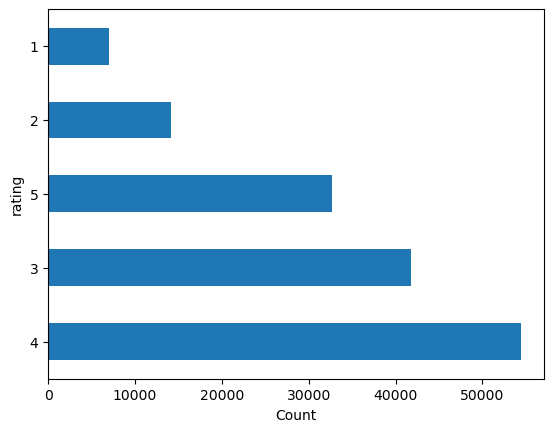

In [79]:
ratings_count.plot(kind="barh", xlabel="Count");

#### Observation

The vast majority of films are rated favorably or neutral<hr>

### Ratings box plot

In [80]:
ratings.rating.median()

4.0

In [81]:
q1 = np.percentile(ratings.rating, 25)
q3 = np.percentile(ratings.rating, 75)
iqr = q3 - q1
print(f"Q1: {q1}\nQ3:{q3}\nInterquartile Range:{iqr}")

Q1: 3.0
Q3:4.0
Interquartile Range:1.0


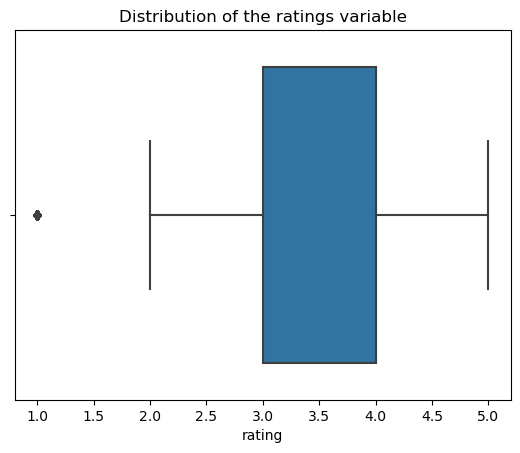

In [82]:
sns.boxplot(x='rating', data=ratings)
plt.title("Distribution of the ratings variable");

#### Observations
- The ratings have a median of 4 and an IQR of 1
- There appears to be outliers at the lower end of the ratings which might indicate class imbalance
<hr>

### Reducing rating categories (Negative: 0, Neutral: 1, Positive: 2)

In [83]:
ratings["category"] = ratings.rating.apply(
    lambda x:
        0 if x == 1 or x == 2 
        else(1 if x ==3 else 2)
)
ratings.head()

,movie,user,rating,category
0,1,1488844,3,1
1,1,822109,5,2
2,1,885013,4,2
3,1,30878,4,2
4,1,823519,3,1


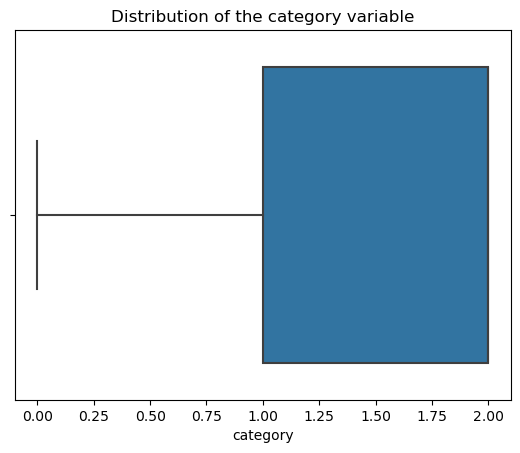

In [84]:
sns.boxplot(x='category', data=ratings)
plt.title("Distribution of the category variable");

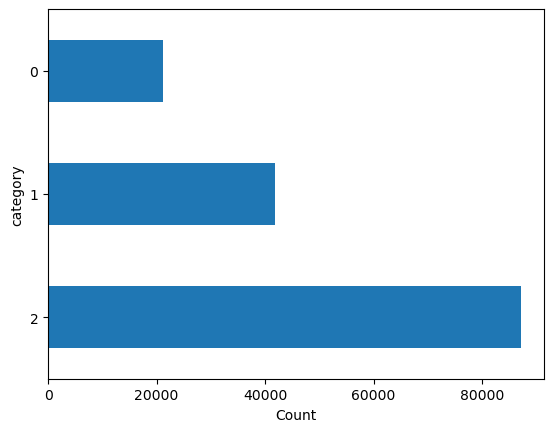

In [85]:
ratings_count = ratings.category.value_counts()
ratings_count.plot(kind="barh", xlabel="Count");

#### Observations
Reducing the categories reduces the strength of the outliers
<hr>

With our rating categories set, we can drop the original rating column

In [86]:
ratings.drop("rating", axis=1, inplace=True)
ratings

,movie,user,category
0,1,1488844,1
1,1,822109,2
2,1,885013,2
3,1,30878,2
4,1,823519,1
...,...,...,...
149995,30,663627,2
149996,30,450324,1
149997,30,2638972,1
149998,30,1696063,2


### Heatmap

In [87]:
ratings_corr =  ratings.corr()
ratings_corr

,movie,user,category
movie,1.000000,-0.001480,0.186167
user,-0.001480,1.000000,0.002439
category,0.186167,0.002439,1.000000


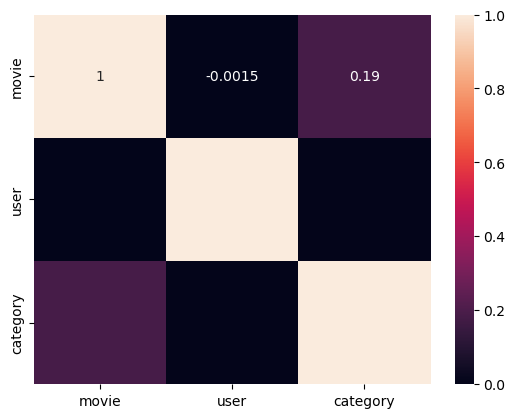

In [88]:
sns.heatmap(ratings_corr, annot=True);

#### Observations
There appears to be no strong correlation between any of the variables. This indicates a non-linear more omplex relationship

## Modeling

In [89]:
y = ratings.category
X = ratings.drop("category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [90]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_preds) * 100, 2)}%")

Accuracy: 46.76%


In [91]:
"""fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = ratings.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()"""

"fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)\ntree.plot_tree(clf,\n               feature_names = ratings.columns, \n               class_names=np.unique(y).astype('str'),\n               filled = True)\nplt.show()"

<hr>

In [92]:
clf_cv = DecisionTreeClassifier()
dt_cv_score = cross_val_score(clf_cv, X_train, y_train, cv=5)
mean_dt_cv_score = np.mean(dt_cv_score)

print(f"Mean Cross Validation Score: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score: 46.67%


<hr>

### Hyperparameter Tuning

In [93]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    'max_features': [None, 'sqrt', 'log2'],
}
clf_grid = DecisionTreeClassifier()
grid = GridSearchCV(estimator=clf_grid, param_grid=param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Best Parameters:", best_params)


# Get the best estimator
best_estimator = grid.best_estimator_
y_preds_grid = best_estimator.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_preds_grid) * 100, 2)}%")


Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Accuracy: 59.68%


In [96]:
tuned_tree = DecisionTreeClassifier(criterion="gini", max_depth=6, max_features=None, min_samples_leaf=5, min_samples_split=2)
tuned_tree.fit(X_train, y_train)
y_preds = tuned_tree.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_preds) * 100, 3)}%")

Accuracy: 59.684%


#### Observations
With optimal parameters the model's accuracy increases by over 10%<hr>

In [103]:
bagged_tree =  BaggingClassifier(tuned_tree, n_estimators=20)
bagged_tree.fit(X_train, y_train)
train_score = bagged_tree.score(X_train, y_train)
test_score = bagged_tree.score(X_test, y_test)
print(f"Training score:{train_score}\nTest score: {test_score}")

Training score:0.5975904761904762
Test score: 0.5973555555555555


In [104]:
forest = RandomForestClassifier(n_estimators=20, max_depth= 5)
forest.fit(X_train, y_train)
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)
print(f"Training score:{train_score}\nTest score: {test_score}")

Training score:0.5862190476190476
Test score: 0.5871111111111111


todo

add year to dataset
try forest
other models
drop ratings = 1 accuracy